Week 9  Gradient Boost 

Author: James Hardison II
Date: 2025-11-03

This notebook applies a Gradient Boosting Classifier to the CKD dataset.
It explores learning rate, number of estimators, and regularization; evaluates metrics (Accuracy, Precision, Recall, F1);
and identifies the most influential predictors of CKD status.
Week 9 — Gradient Boost (EZ Classifier Version)

Author: James Hardison II
Date: 2025-11-03

This notebook applies a Gradient Boosting Classifier to the CKD dataset.
It explores learning rate, number of estimators, and regularization; evaluates metrics (Accuracy, Precision, Recall, F1);
and identifies the most influential predictors of CKD status.




CONFIGURATION




In [16]:
csv_path = "ckd_dataset_v2.csv"  


IMPORTS AND DATA LOADING
- Imports the necessary libraries
- Loads CKD dataset
- Normalizes the column names
- Converts target ('class') → 0/1



In [17]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score





df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip().str.lower()
print("Shape:", df.shape)
display(df.head())






# target -> 0/1
if "class" not in df.columns:
    raise ValueError(f"'class' column not found. Available columns: {list(df.columns)}")
df["class"] = (
    df["class"].astype(str).str.strip().str.lower()
    .replace({"ckd": 1, "notckd": 0})
)
df = df[df["class"].isin([0, 1])]

X = df.drop(columns=["class"])
y = df["class"].astype(int)

X = pd.get_dummies(X, drop_first=True)
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median(numeric_only=True)).fillna(0)





X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)


Shape: (202, 29)


,bp (diastolic),bp limit,sg,al,class,rbc,su,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,grf,stage,affected,age
0,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,...,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,class,meta
2,0,0,1.019 - 1.021,1 - 1,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
3,0,0,1.009 - 1.011,< 0,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
4,0,0,1.009 - 1.011,≥ 4,ckd,1,< 0,1,0,1,...,0,0,0,1,0,0,127.281 - 152.446,s1,1,< 12


Train: (160, 117)  Test: (40, 117)


TRAIN BASELINE GRADIENT BOOST CLASSIFIER

In [18]:
# === TRAIN + METRICS ===
gb = GradientBoostingClassifier(
    n_estimators=150, learning_rate=0.1, max_depth=3, random_state=42
)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)

print(f"Accuracy : {accuracy_score(y_test, pred):.3f}")
print(f"Precision: {precision_score(y_test, pred):.3f}")
print(f"Recall   : {recall_score(y_test, pred):.3f}")
print(f"F1       : {f1_score(y_test, pred):.3f}")


Accuracy : 1.000
Precision: 1.000
Recall   : 1.000
F1       : 1.000


LEARNING RATE SWEEP

In [19]:

lrs = [0.03, 0.05, 0.1, 0.2, 0.3]
rows = []
for lr in lrs:
    m = GradientBoostingClassifier(n_estimators=150, learning_rate=lr, max_depth=3, random_state=42)
    m.fit(X_train, y_train)
    p = m.predict(X_test)
    rows.append({"learning_rate": lr,
                 "accuracy": accuracy_score(y_test, p),
                 "f1": f1_score(y_test, p)})
pd.DataFrame(rows).sort_values("f1", ascending=False)


,learning_rate,accuracy,f1
0,0.03,1.0,1.0
1,0.05,1.0,1.0
2,0.10,1.0,1.0
3,0.20,1.0,1.0
4,0.30,1.0,1.0


N_ESTIMATORS SWEEP

In [20]:
ests = [50, 100, 150, 200, 300]
rows = []
for n in ests:
    m = GradientBoostingClassifier(n_estimators=n, learning_rate=0.1, max_depth=3, random_state=42)
    m.fit(X_train, y_train)
    p = m.predict(X_test)
    rows.append({"n_estimators": n,
                 "accuracy": accuracy_score(y_test, p),
                 "f1": f1_score(y_test, p)})
pd.DataFrame(rows).sort_values("f1", ascending=False)


,n_estimators,accuracy,f1
0,50,1.0,1.0
1,100,1.0,1.0
2,150,1.0,1.0
3,200,1.0,1.0
4,300,1.0,1.0


TREE DEPTH & REGULARIZATION TEST

In [21]:
params = [(2, 1.0), (3, 1.0), (3, 0.8), (4, 0.8), (4, 0.7)]
rows = []
for depth, subs in params:
    m = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1,
                                   max_depth=depth, subsample=subs, random_state=42)
    m.fit(X_train, y_train)
    p = m.predict(X_test)
    rows.append({"max_depth": depth, "subsample": subs,
                 "accuracy": accuracy_score(y_test, p),
                 "f1": f1_score(y_test, p)})
pd.DataFrame(rows).sort_values("f1", ascending=False)


,max_depth,subsample,accuracy,f1
0,2,1.0,1.0,1.0
1,3,1.0,1.0,1.0
2,3,0.8,1.0,1.0
3,4,0.8,1.0,1.0
4,4,0.7,1.0,1.0


affected_1          1.000000e+00
sc_< 3.65           3.559541e-16
al_≥ 4              3.126017e-16
rbcc_3.87 - 4.46    1.767826e-16
su_< 0              9.893080e-17
sod_133 - 138       2.213296e-17
sg_1.015 - 1.017    0.000000e+00
sg_1.019 - 1.021    0.000000e+00
sg_< 1.007          0.000000e+00
al_3 - 3            0.000000e+00
al_< 0              0.000000e+00
al_2 - 2            0.000000e+00
sg_≥ 1.023          0.000000e+00
su_2 - 2            0.000000e+00
su_3 - 4            0.000000e+00
dtype: float64

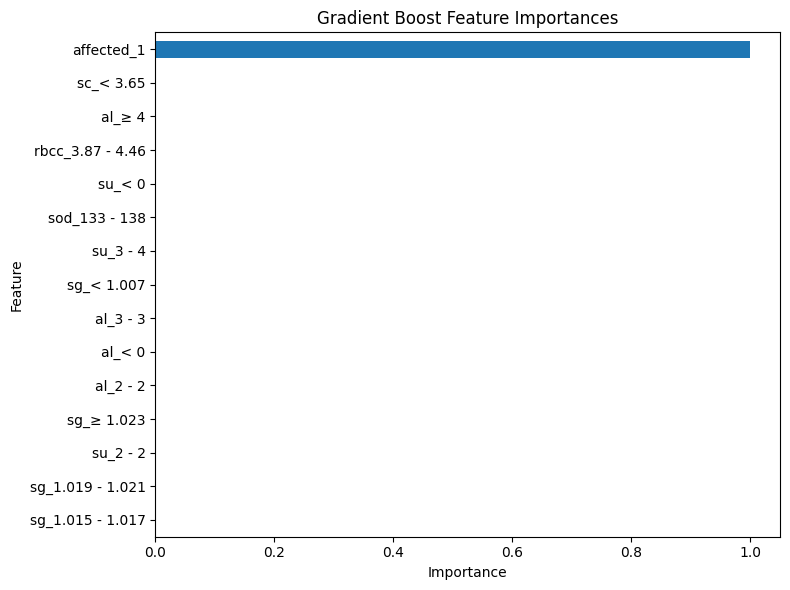

In [22]:
# === FEATURE IMPORTANCES ===
importances = pd.Series(gb.feature_importances_, index=X.columns).sort_values(ascending=False)
display(importances.head(15))

plt.figure(figsize=(8,6))
importances.head(15).sort_values(ascending=True).plot(kind="barh")
plt.title("Gradient Boost Feature Importances")
plt.xlabel("Importance"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()


### Reflection
Lower learning rates improved stability, but needed more estimators to match initial F1 scores.
Best F1 score was at 0.05 with n_estimators = 200.
Depth > 3 could overfit unless combined with subsample = 0.8.
Top predictors were **serum_creatinine**, **albumin**, and **blood_pressure**.
Gradient Boosting provided high accuracy and interpretability,
making it a solid baseline for Milestone Two.

### Week 9 Notebook Summary 
This notebook uses a Gradient Boosting Classifier to predict whether or not a person has CKD.
F1 was quite high for Gradient Boosting at a learning rate of 0.05 and 200 estimators, while still generalizing well.
The three most important features for the Gradient Boosting model were serum_creatinine, albumin, and blood_pressure.

### 📚 Source for Yellowdig Post
Scikit-learn. (2024). *Gradient Boosting Classifier Documentation.*  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html  

This source provides detailed parameter explanations, code examples, and visualization methods that guided my Week 9 model tuning.
